In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import lu_factor, lu_solve
from matplotlib.image import imread

plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams.update({'font.size': 12})

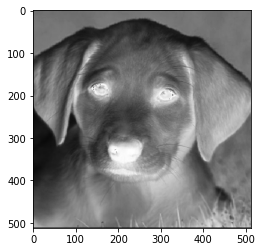

In [37]:
A = imread(os.path.join("data", "dog.jpg"))
plt.imshow(1 - A[:,:,1], cmap="gray", vmin = 0, vmax = 255, interpolation = None)
plt.show()

## Exercise 1

In [3]:
U, S, VT = np.linalg.svd(A[:,:,1], full_matrices = True)

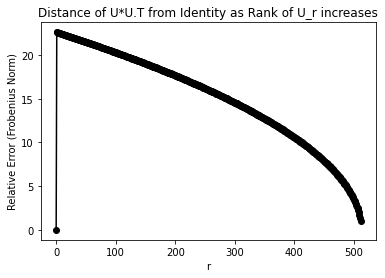

In [4]:
from plots import plot_distance_from_identity

plot_distance_from_identity(U, relative = False)

## Exercise 2

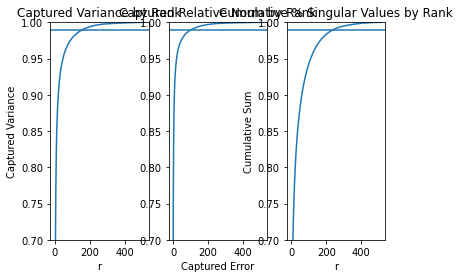

In [5]:
from plots import plot_reconstruction_metrics_vs_rank

plot_reconstruction_metrics_vs_rank(A[:,:,1])

## Exercise 3

In [6]:
content = loadmat(os.path.join("data", "allFaces.mat"))
faces = content['faces']
m = int(content['m'])
n = int(content['n'])
nfaces = np.ndarray.flatten(content['nfaces'])

In [7]:
trainingFaces = faces[:, : np.sum(nfaces[:36])]
avgFace = np.mean(trainingFaces, axis=1)

X = trainingFaces - np.tile(avgFace, (trainingFaces.shape[1], 1)).T

In [8]:
Ust, Sst, VTst = np.linalg.svd(X, full_matrices=False)

In [142]:
S, V = np.linalg.eigh(X.T @ X)
S2 = S  # Eigenvalues of covariance matrix
S = np.sqrt(S)  # Singular Values for Constructing U using the snapshot method
S2I = np.linalg.inv(np.diag(S2))  # Inverse Sigma Squared
SI = np.linalg.inv(np.diag(S)) # Inverse Sigma

# Remove singular values that are basically 0
idx = []
for i in range(np.diag(S).shape[1]):
    if np.any(SI[:, i-1] > 1000):
        idx.append(i-1)
SI = np.delete(SI, idx, axis=0)
S2I = np.delete(S2I, idx, axis=0)
V = np.delete(V, idx, axis=1)

# Compute U approximation
U = X @ (V @ SI)
U_strange = X @ (V @ S2I)

# Sort by magnitude of corresponding singular values
sort_idx = np.argsort(S)[::-1]
sort_idx2 = np.argsort(S2)[::-1]
sort_idx3 = np.argsort(np.delete(S, idx, axis=0))[::-1]

In [143]:
S = np.sort(S)[::-1]
S2 = np.sort(S2)[::-1]
U = U[:, sort_idx]
U_strange = U_strange[:, sort_idx2]
V = V[:, sort_idx3]

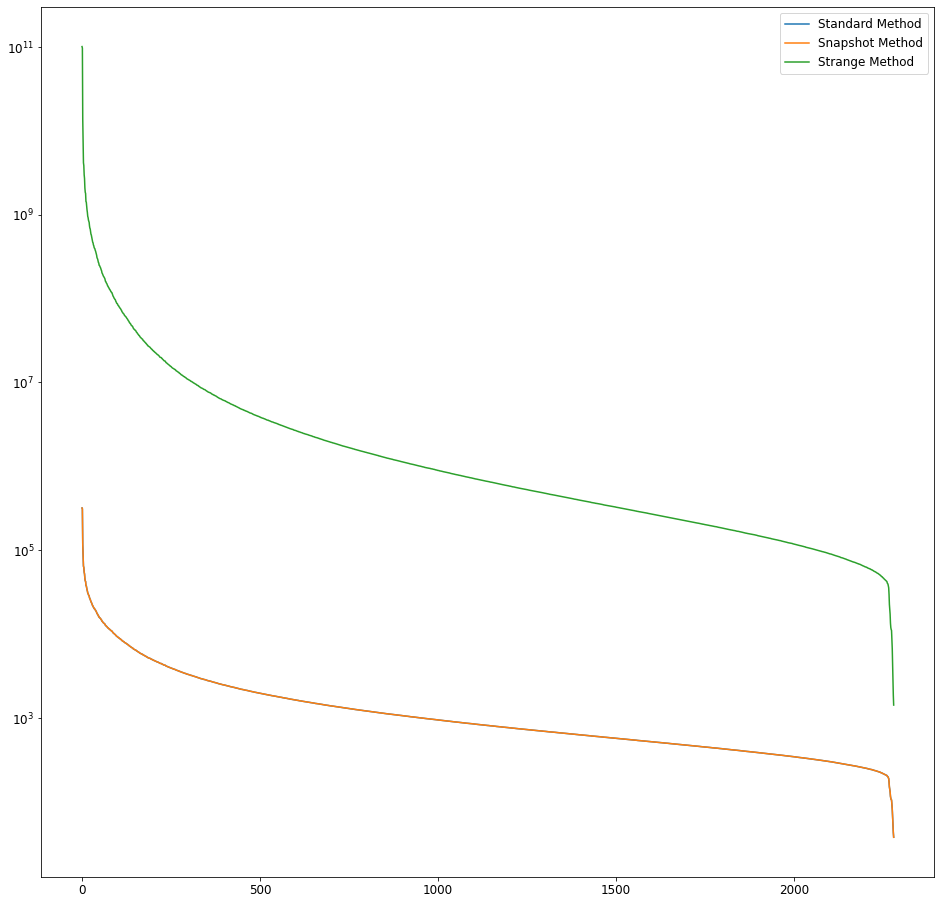

In [144]:
plt.semilogy(np.delete(Sst, -1, axis=0), label="Standard Method")
plt.semilogy(np.delete(S, -1, axis=0), label="Snapshot Method")
plt.semilogy(np.delete(S2, -1, axis=0), label="Strange Method")
plt.legend()
plt.show()

In [145]:
testFace = faces[:, np.sum(nfaces[:36])]
testFaceMS = testFace - avgFace
reconFace_std = Ust[:, :10] @ Ust[:, :10].T @ testFaceMS
reconFace_snap = U[:, :10] @ U[:, :10].T @ testFaceMS
reconFace_strange = U_strange[:, :10] @ U_strange[:, :10].T @ testFaceMS

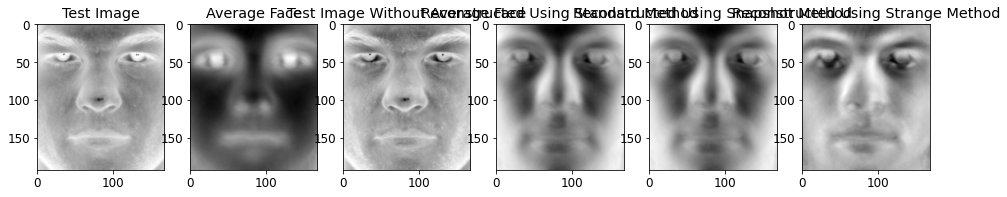

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=6)
ax[0].imshow(1 - np.reshape(testFace, (m, n)).T, cmap="gray")
ax[0].set_title("Test Image")
ax[1].imshow(1 - np.reshape(avgFace, (m, n)).T, cmap="gray")
ax[1].set_title("Average Face")
ax[2].imshow(1 - np.reshape(testFaceMS, (m, n)).T, cmap="gray")
ax[2].set_title("Test Image Without Average Face")
ax[3].imshow(1 - np.reshape(reconFace_std, (m,n)).T, cmap="gray")
ax[3].set_title("Reconstructed Using Standard Method")
ax[4].imshow(1 - np.reshape(reconFace_snap, (m, n)).T, cmap="gray")
ax[4].set_title("Reconstructed Using Snapshot Method")
ax[5].imshow(1 - np.reshape(reconFace_strange, (m, n)).T, cmap="gray")
ax[5].set_title("Reconstructed Using Strange Method")
plt.show()

In [151]:
reconFace2_std = Ust[:, 11:21] @ Ust[:, 11:21].T @ testFaceMS
reconFace2_snap = U[:, 11:21] @ U[:, 11:21].T @ testFaceMS
reconFace2_strange = U_strange[:, 11:21] @ U_strange[:, 11:21].T @ testFaceMS

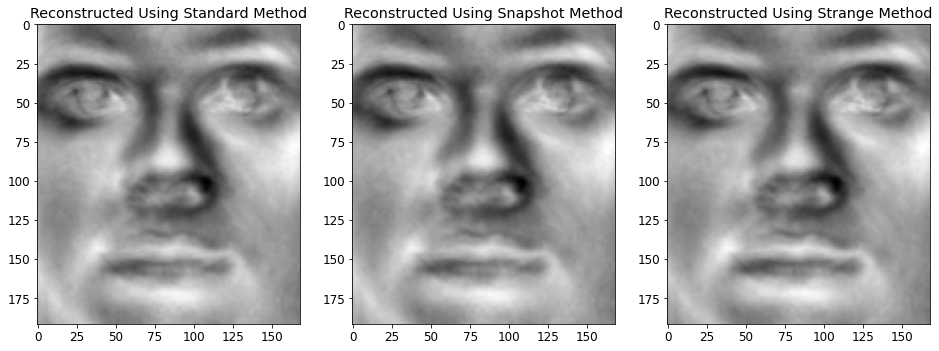

In [153]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(1 - np.reshape(reconFace2_std, (m, n)).T, cmap="gray")
ax[0].set_title("Reconstructed Using Standard Method")
ax[1].imshow(1 - np.reshape(reconFace2_snap, (m, n)).T, cmap="gray")
ax[1].set_title("Reconstructed Using Snapshot Method")
ax[2].imshow(1 - np.reshape(reconFace2_strange, (m, n)).T, cmap="gray")
ax[2].set_title("Reconstructed Using Strange Method")
plt.show()

In [154]:
reconFace3_std = Ust[:, :400] @ Ust[:, :400].T @ testFaceMS
reconFace3_snap = U[:, :400] @ U[:, :400].T @ testFaceMS
reconFace3_strange = U_strange[:, :400] @ U_strange[:, :400].T @ testFaceMS

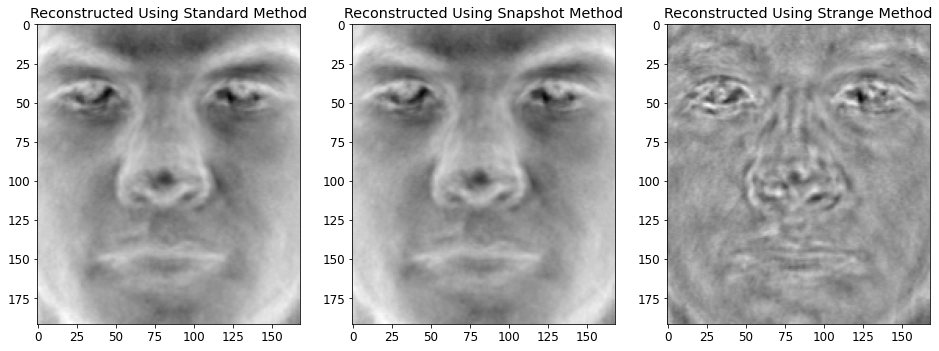

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(1 - np.reshape(reconFace3_std, (m,n)).T, cmap="gray")
ax[0].set_title("Reconstructed Using Standard Method")
ax[1].imshow(1 - np.reshape(reconFace3_snap, (m, n)).T, cmap="gray")
ax[1].set_title("Reconstructed Using Snapshot Method")
ax[2].imshow(1 - np.reshape(reconFace3_strange, (m, n)).T, cmap="gray")
ax[2].set_title("Reconstructed Using Strange Method")

plt.show()

The reconstructions are indistinguishable. Just remember to square root the eigenvalues you obtain from the eigendecomposition and you won't make a silly mistake like me! What I found really interesting was that the low-rank reconstructions were seemingly better when I accidentally used the eigenvalues from the eigendecomposition of X^T * X instead of the singular values that we obtain from an element-wise square root of sigma across the diagonal. The "better" appearance of the lower rank approximation from the strange method could just be a consequence of the picture being darker (as I would expect from squaring sigma). I don't see anything noticeably different from the other reconstructions other than the darkness.

## Exercise 4

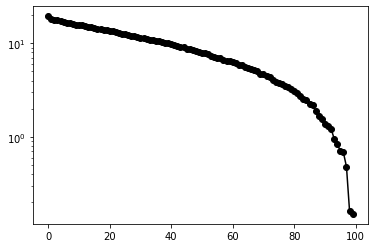

In [2]:
# Step 1 - Generate 100 x 100 matrix whose entries are sampled from a normal distribution
X = np.random.randn(100, 100)

# Step 2 - Compute SVD of X
U, S, VT = np.linalg.svd(X, full_matrices=False)

# Step 3 - Plot singular values
plt.semilogy(S, "-o", color="k")
plt.show()



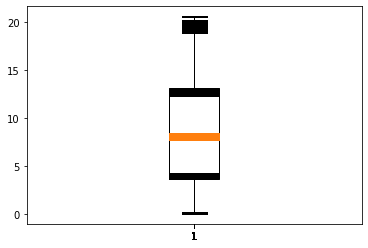

In [4]:
# Compute and Plot distribution of singular values for 100 rxr matrices with standard normal entries
r = 100
X = np.random.randn(r, r, 100)
svdist = np.zeros((r,100))
for i in range(100):
    svdist[:, i] = np.sort(np.sqrt(np.linalg.eigvalsh(X[:,:,i].T @ X[:,:,i])))[::-1]
    box = plt.boxplot(svdist[:, i])
plt.show()

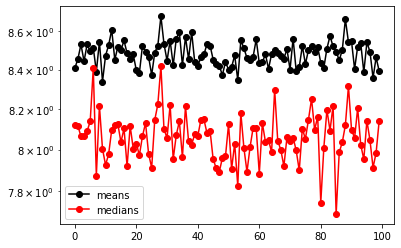

In [5]:
sv_means = np.mean(svdist, axis=0)
sv_medians = np.median(svdist, axis=0)
plt.semilogy(sv_means, "-o", color="k", label="means")
plt.semilogy(sv_medians, "-o", color="r", label="medians")
plt.legend()
plt.show()

In [8]:
# Warning: Takes Eternity, Probably Should Do This Sklearn lol
# fig, axs = plt.subplots(nrows=5, ncols=2)
# r_list = [25, 50, 200, 500, 1000]
# for r in range(len(r_list)):
#     tmp = np.random.randn(r_list[r], r_list[r], 100)
#     svdist_tmp = np.zeros((r_list[r],100))
#     for i in range(100):
#         svdist_tmp[:, i] = np.sqrt(np.linalg.eigvalsh(tmp[:,:,i].T @ tmp[:,:,i]))
#         axs[r, 0] = plt.boxplot(svdist_tmp[:, i])
#     axs[r, 1].semilogy(np.mean(svdist_tmp, axis=0), "-o", color="k", label="means")
#     axs[r, 1].semilogy(np.median(svdist_tmp, axis=0), "-o", color="r", label="medians")
#
# plt.show()

## Exercise 5

In [20]:
# Step 1 - Generate 1000x1000 Gaussian and Uniform Matrices

unifd = np.random.rand(1000, 1000)
normd = np.random.randn(1000, 1000)

Uu, Su, VTu = np.linalg.svd(unifd, full_matrices=False)
Un, Sn, VTn = np.linalg.svd(normd, full_matrices=False)

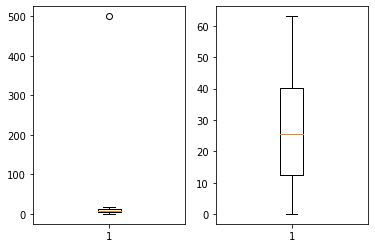

In [78]:
# Step 2 - Plot singular value distributions
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].boxplot(Su)
ax[1].boxplot(Sn)
plt.show()

In [32]:

# Step 3 - Compute Truncation Coefficient

# Since both matrices are square
unif_cutoff = (4/math.sqrt(3))*math.sqrt(1000)*(1/12)
print(unif_cutoff)
r = np.max(np.where(Su > unif_cutoff))
unifd_clean = Uu[:, :(r+1)] @ np.diag(Su[:(r+1)]) @ VTu[:(r+1), :]
unifd_clean

6.0858061945018465


array([[0.94317248, 0.42413519, 0.4959266 , ..., 0.40041197, 0.37109787,
        0.51414033],
       [0.14990798, 0.66701692, 0.92211532, ..., 0.40926828, 0.36153453,
        0.2263377 ],
       [0.12276938, 0.33429582, 0.80199329, ..., 0.54850839, 0.3226021 ,
        0.82543027],
       ...,
       [0.55126481, 0.89946332, 0.83572409, ..., 0.63293958, 0.77805185,
        0.3550734 ],
       [0.91833153, 0.64208334, 0.48002293, ..., 0.7612799 , 0.28100305,
        0.18507612],
       [0.2503287 , 0.0995545 , 0.70708239, ..., 0.16523816, 0.19760349,
        0.11680184]])

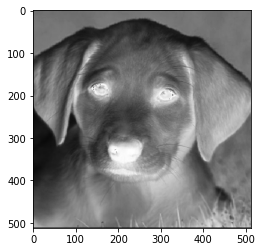

In [121]:
X_true = A[:,:,1]
low = 0.0
high = 255.0
loc = 178
scale = 50
X_noise = np.random.uniform(low,high, (512,512))
X_loggaussian_noise = np.random.lognormal(loc, scale, (512,512))
X = X_true + X_noise
X2 = X_true + np.log(X_loggaussian_noise)
plt.imshow(1 - X_true, cmap="gray")
plt.show()

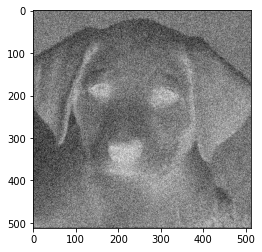

In [111]:
plt.imshow(1 - X, cmap="gray")
plt.show()

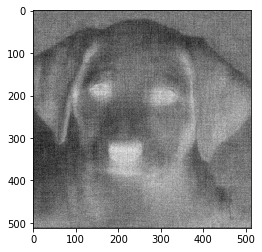

In [123]:
XWS = X - np.tile((high+low/2), (X.shape[0], X.shape[1]))
U, S, VT = np.linalg.svd(X, full_matrices=False)
gamma = math.sqrt(((high-low)**2)/12)
cutoff = (4/math.sqrt(3))*math.sqrt(512)*gamma
r = np.max(np.where(S > cutoff))
X_cleaned = XWS + U[:, :(r+1)] @ np.diag(S[:(r+1)]) @ VT[:(r+1), :]
plt.imshow(1 - X_cleaned, cmap="gray")

Honestly, I feel like the denoising made the noisy image aesthetically worse in the reconstruction sense but cooler in the heavy metal sense. I am evenly split on whether I like this hard threshold denoising method as a result. It does a pretty good job for low levels of noise, though.

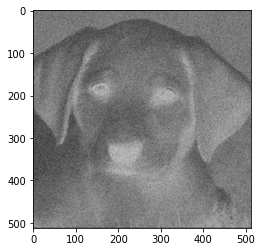

In [120]:
plt.imshow(1 - X2, cmap="gray")
plt.show()

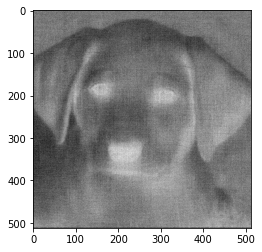

In [122]:
avg = 30
X2WS = X2 - np.tile(avg, (X2.shape[0], X2.shape[1]))
U, S, VT = np.linalg.svd(X2WS, full_matrices=False)
gamma = 60
cutoff = (4/math.sqrt(3))*math.sqrt(512)*gamma
r = np.max(np.where(S > cutoff))
X_cleaned = X2WS + U[:, :(r+1)] @ np.diag(S[:(r+1)]) @ VT[:(r+1), :]
plt.imshow(1 - X_cleaned, cmap="gray")

## Exercise 6

### part a

"If a matrix X has low-rank structure, then there are extremely efficient matrix decomposition algorithms based on the theory of random sampling."
"Moreover, with increasingly vast measurements, it is often the case that the intrinsic rank of the data does not increase appreciably, even though the dimension of the ambient measurement space grows. Thus, the computational savings of randomized methods will only become more important in the coming years and decades with the growing deluge of data."

We assume that we are working with tall-skinny matrices (though the theory readily generalizes to short-fat matrices)

Step 0: Identify a target r < m
Step 1: Using random projections P to sample the column space, find a matrix Q whose columns approximate the column space of X; i.e., so that X approximates QQ*X
Step 2: Project X onto the Q subspace, Y = Q*X, and compute the matrix decomposition on Y
Step 3: Reconstruct high-dimensional modes U = QU_{Y} using Q and the modes computed from Y


In [ ]:
# Step 1 - Construct a random projection matrix P

In [2]:
# Step 1 - Generate two random 100x100 matrices
U = np.random.randn(100,100)
V = np.random.randn(100,100)
S1 = np.logspace(0, 2, 100)
S2 = np.logspace(-6, 2, 100)
A1 = U @ np.diag(S1) @ V.T
A2 = U @ np.diag(S2) @ V.T
b = np.random.randn(100,1)
eps = np.random.randn(100,1) / (np.linalg.norm(b)*(1E6))
b2 = b + eps

In [294]:
S2.max()/S2.min()

100000000.0

In [284]:
S2.max()/S2.min()

605526541664.693

This experiment will plot the distribution of the errors across multiple epsilons.

See: https://stackoverflow.com/questions/51448366/scipy-linalg-lu-vs-scipy-linalg-lu-factor

In [1]:
# I'm guessing the book wants me to solve for X using Inversion and SVD/rSVD mixed LU Decomposition. The text doesn't specify
import numpy as np
from SVDErrorSimulator import SVDErrorSimulator


rng = np.random.default_rng()
out_bitgen_method = rng.uniform
eps_bitgen_method = rng.uniform
r = None
q = 1
p = 5
U = rng.uniform(0, 20, (100, 100))
V = rng.uniform(0, 20, (100, 100))
S1 = np.logspace(0, 2, 100)
S2 = np.logspace(-6, 2, 100)
S3 = np.linspace(1, 100, 100)
A1 = U @ np.diag(S1) @ V.T
A2 = U @ np.diag(S2) @ V.T
A3 = U @ np.diag(S3) @ V.T


In [2]:
sim1 = SVDErrorSimulator(A=A1,
                         r=r,
                         svd_method="standard",
                         p=p,
                         q=q,
                         out_bitgen_method=out_bitgen_method,
                         eps_bitgen_method=eps_bitgen_method)

(100,)


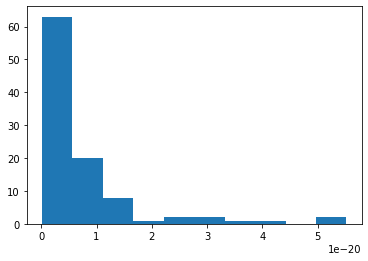

In [3]:
sim1.simulate(method="pinv")

(100,)


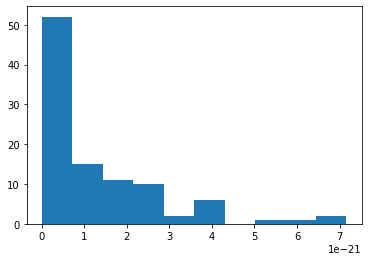

In [4]:
sim1.simulate(method="lu")

In [7]:
sim1._b_mat - (sim1._A @ sim1.solutions)

array([[ 5.21699350e-11,  3.71263020e-11,  2.43861598e-11, ...,
         3.17013082e-11,  7.16116055e-12, -1.96143102e-11],
       [ 2.90256708e-11,  3.39233086e-11,  2.27706742e-11, ...,
         1.61907154e-11,  1.64668279e-12, -1.80462312e-11],
       [ 4.98956432e-12, -1.07611697e-11,  2.50253152e-11, ...,
         8.37374614e-12,  1.37696521e-11,  6.71263045e-12],
       ...,
       [-1.13737908e-11, -3.13751247e-11, -1.12787557e-11, ...,
        -7.31881222e-12, -9.10127529e-12, -1.32875932e-11],
       [ 1.74182890e-12, -2.36990427e-11,  6.07378037e-12, ...,
         3.87789800e-12,  2.21190288e-11,  1.99465722e-11],
       [-1.52465818e-11,  2.99743563e-12, -6.76747547e-12, ...,
        -6.52788934e-12, -6.38566977e-12, -4.70379291e-12]])

In [376]:
eps = np.random.rand(100, 100)
beps_mat = b + eps
result = np.repeat(beps_mat[:, : , np.newaxis], 4, axis=2)
b_mat = np.repeat(b[:, np.newaxis], 100, axis=1)

In [350]:
reconstructed_A1_svd = U1[:, :(r+1)] @ np.diag(S1[:(r+1)]) @ VT1[:(r+1), :]
reconstructed_A1_rsvd = RU1[:, :(r+1)] @ np.diag(RS1[:(r+1)]) @ RVT1[:(r+1), :]
reconstructed_A2_svd = U2[:, :(r+1)] @ np.diag(S2[:(r+1)]) @ VT2[:(r+1), :]
reconstructed_A2_rsvd = RU2[:, :(r+1)] @ np.diag(RS2[:(r+1)]) @ RVT2[:(r+1), :]

##### Using Inverse To Solve For x

In [351]:
# Since A1 and A2 are square
xtilde_inv1 = np.linalg.inv(A1) @ beps_mat
xtilde_inv2 = np.linalg.inv(A2) @ beps_mat

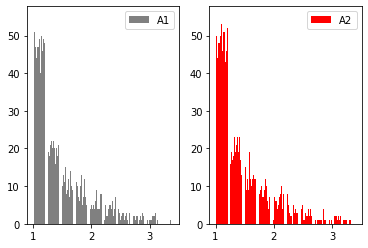

In [361]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].hist(np.apply_along_axis(np.linalg.norm, 0, b_mat - (A1 @ xtilde_inv1), ord=2) / np.apply_along_axis(np.linalg.norm, 0, b_mat, ord=2), label="A1", facecolor="gray")
ax[0].legend()
ax[1].hist(np.apply_along_axis(np.linalg.norm, 0, b_mat - (A2 @ xtilde_inv2), ord=2) / np.apply_along_axis(np.linalg.norm, 0, b_mat, ord=2), label="A2", facecolor="red")
ax[1].legend()
plt.show()

##### Using LU Decomposition To Solve For x

In [384]:
eps = np.random.rand(100, 100)
beps_mat = b + eps
result = np.repeat(beps_mat[:, :, np.newaxis], 4, axis=2)
b_mat = np.repeat(b , 100, axis=1)

recon_svd_A1_lu, svd_A1_lu_piv = lu_factor(reconstructed_A1_svd)
recon_rsvd_A1_lu, rsvd_A1_lu_piv = lu_factor(reconstructed_A1_rsvd)
recon_svd_A2_lu, svd_A2_lu_piv = lu_factor(reconstructed_A2_svd)
recon_rsvd_A2_lu, rsvd_A2_lu_piv = lu_factor(reconstructed_A2_rsvd)

In [385]:
x_list = ["xtilde_A1_svd", "xtilde_A1_rsvd", "xtilde_A2_svd", "xtilde_A2_rsvd"]
for i in range(beps_mat.shape[1]):
    lu_solve((recon_svd_A1_lu, svd_A1_lu_piv), result[:,i,0], overwrite_b=True)
    lu_solve((recon_rsvd_A1_lu, rsvd_A1_lu_piv), result[:,i,1], overwrite_b=True)
    lu_solve((recon_svd_A2_lu, svd_A2_lu_piv), result[:,i,2], overwrite_b=True)
    lu_solve((recon_rsvd_A2_lu, rsvd_A2_lu_piv), result[:,i,3], overwrite_b=True)

In [386]:
errs_lu = np.ones((beps_mat.shape[0], 4))
errs_lu[:,0] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A1 @ result[:, :, 0]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, b_mat, ord=2)
errs_lu[:,1] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A1 @ result[:, :, 1]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, b_mat, ord=2)
errs_lu[:,2] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A2 @ result[:, :, 2]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, b_mat, ord=2)
errs_lu[:,3] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A2 @ result[:, :, 3]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, b_mat, ord=2)

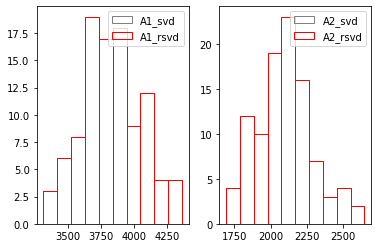

In [389]:
fig, ax = plt.subplots(nrows=1, ncols=2)
labels = ["A1_svd", "A1_rsvd", "A2_svd", "A2_rsvd"]
ax[0].hist(errs_lu[:, 0], label=labels[0], facecolor="none", edgecolor="gray")
ax[0].hist(errs_lu[:, 1], label=labels[1], facecolor="none", edgecolor="red")
ax[0].legend()
ax[1].hist(errs_lu[:, 2], label=labels[2], facecolor="none", edgecolor="gray")
ax[1].hist(errs_lu[:, 3], label=labels[3], facecolor="none", edgecolor="red")
ax[1].legend()
plt.show()

##### Using original A matrices

#### part c

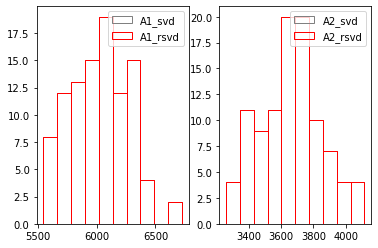

In [392]:
U = np.random.randn(100,100)
V = np.random.randn(100,100)
S1 = np.linspace(1, 100, 100)
S2 = np.logspace(0, 2, 100)
A1 = U @ np.diag(S1) @ V.T
A2 = U @ np.diag(S2) @ V.T
eps = np.random.rand(100, 100)
beps_mat = b + eps
result = np.repeat(beps_mat[:, : , np.newaxis], 4, axis=2)

U1, S1, VT1 = np.linalg.svd(A1, full_matrices=False)
U2, S2, VT2 = np.linalg.svd(A2, full_matrices=False)
RU1, RS1, RVT1 = rSVD(A1, r, q, p)
RU2, RS2, RVT2 = rSVD(A2, r, q, p)

reconstructed_A1_svd = U1[:, :(r+1)] @ np.diag(S1[:(r+1)]) @ VT1[:(r+1), :]
reconstructed_A1_rsvd = RU1[:, :(r+1)] @ np.diag(RS1[:(r+1)]) @ RVT1[:(r+1), :]
reconstructed_A2_svd = U2[:, :(r+1)] @ np.diag(S2[:(r+1)]) @ VT2[:(r+1), :]
reconstructed_A2_rsvd = RU2[:, :(r+1)] @ np.diag(RS2[:(r+1)]) @ RVT2[:(r+1), :]

recon_svd_A1_lu, svd_A1_lu_piv = lu_factor(reconstructed_A1_svd)
recon_rsvd_A1_lu, rsvd_A1_lu_piv = lu_factor(reconstructed_A1_rsvd)
recon_svd_A2_lu, svd_A2_lu_piv = lu_factor(reconstructed_A2_svd)
recon_rsvd_A2_lu, rsvd_A2_lu_piv = lu_factor(reconstructed_A2_rsvd)

for i in range(beps_mat.shape[1]):
    lu_solve((recon_svd_A1_lu, svd_A1_lu_piv), result[:,i,0], overwrite_b=True)
    lu_solve((recon_rsvd_A1_lu, rsvd_A1_lu_piv), result[:,i,1], overwrite_b=True)
    lu_solve((recon_svd_A2_lu, svd_A2_lu_piv), result[:,i,2], overwrite_b=True)
    lu_solve((recon_rsvd_A2_lu, rsvd_A2_lu_piv), result[:,i,3], overwrite_b=True)

errs_lu = np.ones((beps_mat.shape[0], 4))
errs_lu[:,0] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A1 @ result[:, :, 0]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, beps_mat, ord=2)
errs_lu[:,1] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A1 @ result[:, :, 1]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, beps_mat, ord=2)
errs_lu[:,2] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A2 @ result[:, :, 2]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, beps_mat, ord=2)
errs_lu[:,3] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A2 @ result[:, :, 3]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, beps_mat, ord=2)

fig, ax = plt.subplots(nrows=1, ncols=2)
labels = ["A1_svd", "A1_rsvd", "A2_svd", "A2_rsvd"]
ax[0].hist(errs_lu[:, 0], label=labels[0], facecolor="none", edgecolor="gray")
ax[0].hist(errs_lu[:, 1], label=labels[1], facecolor="none", edgecolor="red")
ax[0].legend()
ax[1].hist(errs_lu[:, 2], label=labels[2], facecolor="none", edgecolor="gray")
ax[1].hist(errs_lu[:, 3], label=labels[3], facecolor="none", edgecolor="red")
ax[1].legend()
plt.show()

#### part d

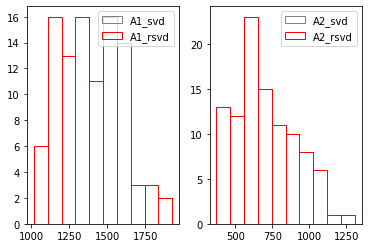

In [393]:
U = np.random.randn(100,10)
V = np.random.randn(100,10)
S1 = np.linspace(1, 100, 10)
S2 = np.logspace(0, 2, 10)
A1 = U @ np.diag(S1) @ V.T
A2 = U @ np.diag(S2) @ V.T

U1, S1, VT1 = np.linalg.svd(A1, full_matrices=False)
U2, S2, VT2 = np.linalg.svd(A2, full_matrices=False)
RU1, RS1, RVT1 = rSVD(A1, r, q, p)
RU2, RS2, RVT2 = rSVD(A2, r, q, p)

reconstructed_A1_svd = U1[:, :(r+1)] @ np.diag(S1[:(r+1)]) @ VT1[:(r+1), :]
reconstructed_A1_rsvd = RU1[:, :(r+1)] @ np.diag(RS1[:(r+1)]) @ RVT1[:(r+1), :]
reconstructed_A2_svd = U2[:, :(r+1)] @ np.diag(S2[:(r+1)]) @ VT2[:(r+1), :]
reconstructed_A2_rsvd = RU2[:, :(r+1)] @ np.diag(RS2[:(r+1)]) @ RVT2[:(r+1), :]

recon_svd_A1_lu, svd_A1_lu_piv = lu_factor(reconstructed_A1_svd)
recon_rsvd_A1_lu, rsvd_A1_lu_piv = lu_factor(reconstructed_A1_rsvd)
recon_svd_A2_lu, svd_A2_lu_piv = lu_factor(reconstructed_A2_svd)
recon_rsvd_A2_lu, rsvd_A2_lu_piv = lu_factor(reconstructed_A2_rsvd)

for i in range(beps_mat.shape[1]):
    lu_solve((recon_svd_A1_lu, svd_A1_lu_piv), result[:,i,0], overwrite_b=True)
    lu_solve((recon_rsvd_A1_lu, rsvd_A1_lu_piv), result[:,i,1], overwrite_b=True)
    lu_solve((recon_svd_A2_lu, svd_A2_lu_piv), result[:,i,2], overwrite_b=True)
    lu_solve((recon_rsvd_A2_lu, rsvd_A2_lu_piv), result[:,i,3], overwrite_b=True)

errs_lu = np.ones((beps_mat.shape[0], 4))
errs_lu[:,0] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A1 @ result[:, :, 0]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, beps_mat, ord=2)
errs_lu[:,1] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A1 @ result[:, :, 1]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, beps_mat, ord=2)
errs_lu[:,2] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A2 @ result[:, :, 2]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, beps_mat, ord=2)
errs_lu[:,3] = np.apply_along_axis(np.linalg.norm, 0, b_mat - (A2 @ result[:, :, 3]), ord=2) / np.apply_along_axis(np.linalg.norm, 0, beps_mat, ord=2)

fig, ax = plt.subplots(nrows=1, ncols=2)
labels = ["A1_svd", "A1_rsvd", "A2_svd", "A2_rsvd"]
ax[0].hist(errs_lu[:, 0], label=labels[0], facecolor="none", edgecolor="gray")
ax[0].hist(errs_lu[:, 1], label=labels[1], facecolor="none", edgecolor="red")
ax[0].legend()
ax[1].hist(errs_lu[:, 2], label=labels[2], facecolor="none", edgecolor="gray")
ax[1].hist(errs_lu[:, 3], label=labels[3], facecolor="none", edgecolor="red")
ax[1].legend()
plt.show()

### Exercise 7